## Import Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

In [2]:
# load dataset and show the first five sample
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/customer_classification_data.csv"
df = pd.read_csv(url)
df.head()

,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
0,66161.01279,57,Bachelor,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693
1,78639.20248,60,High School,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358
2,70207.25321,46,High School,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993
3,65866.23872,42,High School,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473
4,56774.10995,36,Bachelor,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168


# Part A - Data Preparation

In [3]:
# describe data
df.describe()

,Income,Age,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,62244.823110,40.010000,564.992000,10.806000,48.486000,5062.825191,25395.518396,10609.972452,0.512753,2.564000,0.494516
std,21881.731581,13.051229,159.206663,5.151061,28.742339,2926.414765,14257.083307,5572.250431,0.282915,1.101058,0.294468
min,25352.160710,18.000000,300.000000,1.000000,1.000000,44.900440,1087.318821,1017.345471,0.000813,1.000000,0.001320
25%,43586.942127,29.000000,426.000000,7.000000,25.000000,2563.861164,13254.375542,5788.708258,0.272196,2.000000,0.239926
50%,61513.145375,39.000000,562.000000,11.000000,48.000000,4962.940262,25523.286385,10716.457885,0.531370,3.000000,0.485326
75%,79805.933200,51.000000,692.000000,15.000000,72.000000,7575.192218,38359.706343,15530.730127,0.763411,4.000000,0.759197
max,99913.525490,64.000000,849.000000,19.000000,99.000000,9984.440444,49971.895230,19968.520560,0.993942,4.000000,0.999897


In [4]:
# Check for info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Income                 500 non-null    float64
 1   Age                    500 non-null    int64  
 2   Education              500 non-null    object 
 3   Credit_Score           500 non-null    int64  
 4   Years_with_Bank        500 non-null    int64  
 5   Transaction_Count      500 non-null    int64  
 6   Balance                500 non-null    float64
 7   Loan_Approval_Amount   500 non-null    float64
 8   Credit_Card_Limit      500 non-null    float64
 9   Purchase_Frequency     500 non-null    float64
 10  Customer_Satisfaction  500 non-null    int64  
 11  Online_Activity        500 non-null    float64
dtypes: float64(6), int64(5), object(1)
memory usage: 47.0+ KB


In [5]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Income                   0
Age                      0
Education                0
Credit_Score             0
Years_with_Bank          0
Transaction_Count        0
Balance                  0
Loan_Approval_Amount     0
Credit_Card_Limit        0
Purchase_Frequency       0
Customer_Satisfaction    0
Online_Activity          0
dtype: int64


In [6]:
# Check for inconsistent values in object columns
object_cols = df.select_dtypes(include='object').columns

print("\nUnique values in object columns:")
for col in object_cols:
    print(f"\n'{col}':")
    print(df[col].unique())


Unique values in object columns:

'Education':
['Bachelor' 'High School' 'PhD' 'Master']


In [7]:
# Display duplicate rows
df[df.duplicated(keep=False)]

,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity


## Data Transformation

In [8]:
# duplicate df
df_encoded = df.copy()

from sklearn.preprocessing import OrdinalEncoder

# Nominal Encoding
nominal_cols = ['Education']
encoder = OrdinalEncoder(categories=[['High School', 'Bachelor', 'Master', 'PhD']])
df_encoded[nominal_cols] = encoder.fit_transform(df_encoded[nominal_cols])

# Build a mapping dictionary
encode_dict = {}

for col, cats in zip(nominal_cols, encoder.categories_):
    encode_dict[col] = {category: int(code) for code, category in enumerate(cats)}

# Show the full dictionary
import pprint
pprint.pprint(encode_dict)

df_encoded.sample(n = 5)

{'Education': {'Bachelor': 1, 'High School': 0, 'Master': 2, 'PhD': 3}}


,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
112,77460.94565,33,2.0,363,6,21,4713.021881,44195.89313,17792.139610,0.863957,4,0.938916
375,37040.41169,21,2.0,330,16,86,4846.959601,41293.42758,13843.532330,0.001914,4,0.758522
23,83539.68822,63,2.0,573,12,83,8736.807502,43773.15539,6883.113722,0.539751,3,0.321932
336,44456.69233,29,1.0,465,7,67,7660.047423,24884.05523,11563.771690,0.053600,1,0.813463
207,59027.26334,29,1.0,813,15,43,5754.328145,8563.80890,15483.624890,0.260929,4,0.012882


In [9]:
df_encoded.info()

# All features used for clustering are numeric.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Income                 500 non-null    float64
 1   Age                    500 non-null    int64  
 2   Education              500 non-null    float64
 3   Credit_Score           500 non-null    int64  
 4   Years_with_Bank        500 non-null    int64  
 5   Transaction_Count      500 non-null    int64  
 6   Balance                500 non-null    float64
 7   Loan_Approval_Amount   500 non-null    float64
 8   Credit_Card_Limit      500 non-null    float64
 9   Purchase_Frequency     500 non-null    float64
 10  Customer_Satisfaction  500 non-null    int64  
 11  Online_Activity        500 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 47.0 KB


# Part B - Exploratory Data Analysis


/tmp/ipython-input-3172039954.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Customer_Satisfaction', data=df, palette='pastel')


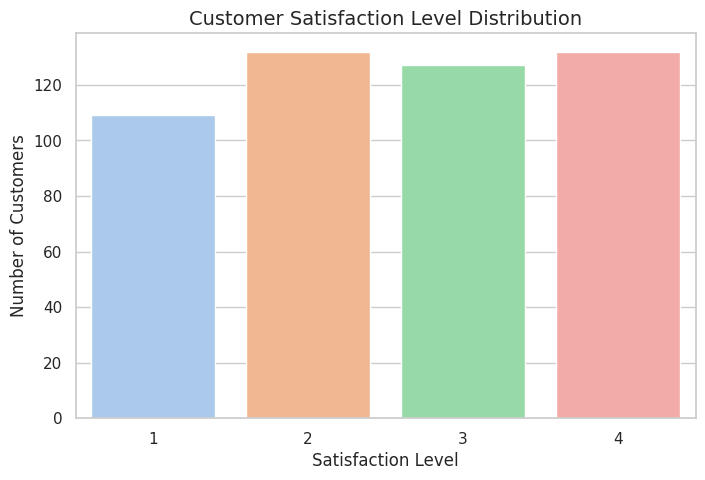

In [10]:
# Set visual style
sns.set(style="whitegrid")

# Create barplot of satisfaction level counts
plt.figure(figsize=(8, 5))
sns.countplot(x='Customer_Satisfaction', data=df, palette='pastel')

# Add title and labels
plt.title('Customer Satisfaction Level Distribution', fontsize=14)
plt.xlabel('Satisfaction Level', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Show plot
plt.show()

**Interpretation:**
1. **Moderate to high satisfaction dominates:**  
   Levels **2, 3, and 4** have the highest number of customers, indicating that most customers are at least somewhat satisfied with the service.

2. **Slight peak at the highest levels:**  
   The counts for **Level 3 and 4** are slightly higher than the middle range, implying that many customers perceive strong value or positive experience.


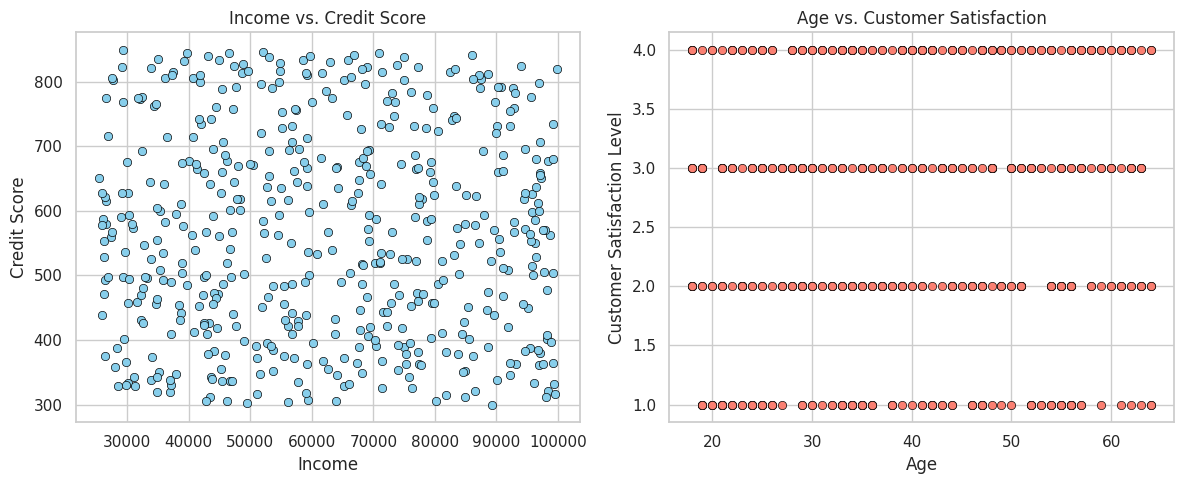

In [11]:
# Set style
sns.set(style="whitegrid")

# Create figure with 2 subplots
plt.figure(figsize=(12, 5))

# --- Scatterplot 1: Income vs Credit_Score ---
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Income', y='Credit_Score', color='skyblue', edgecolor='black')
plt.title('Income vs. Credit Score')
plt.xlabel('Income')
plt.ylabel('Credit Score')

# --- Scatterplot 2: Age vs Customer_Satisfaction ---
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Age', y='Customer_Satisfaction', color='salmon', edgecolor='black')
plt.title('Age vs. Customer Satisfaction')
plt.xlabel('Age')
plt.ylabel('Customer Satisfaction Level')

# Adjust layout
plt.tight_layout()
plt.show()

**Interpretation:**

**1. Income vs. Credit Score**
- The points are **widely scattered** with no strong visible pattern.
- This indicates a **weak or no correlation** between a customer's income and credit score in this dataset.
- Even customers with **high income** can have **low credit scores**, suggesting other factors (like debt management or spending habits) influence credit score more than income.

**2. Age vs. Customer Satisfaction**
- The satisfaction levels are **discrete (1-4)**, forming clear horizontal lines.
- There is **no clear upward or downward trend** across age — meaning **age does not strongly affect customer satisfaction**.
- Satisfaction levels seem **fairly evenly distributed** among different age groups, suggesting customers across all ages have similar experiences with the service.

Customer satisfaction appears **independent of age**, while **credit score is not directly tied to income**. This implies that improving satisfaction or creditworthiness may depend on other behavioral or service-related variables, not demographics alone.



/tmp/ipython-input-84121659.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, palette='pastel')
/tmp/ipython-input-84121659.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, palette='pastel')
/tmp/ipython-input-84121659.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, palette='pastel')


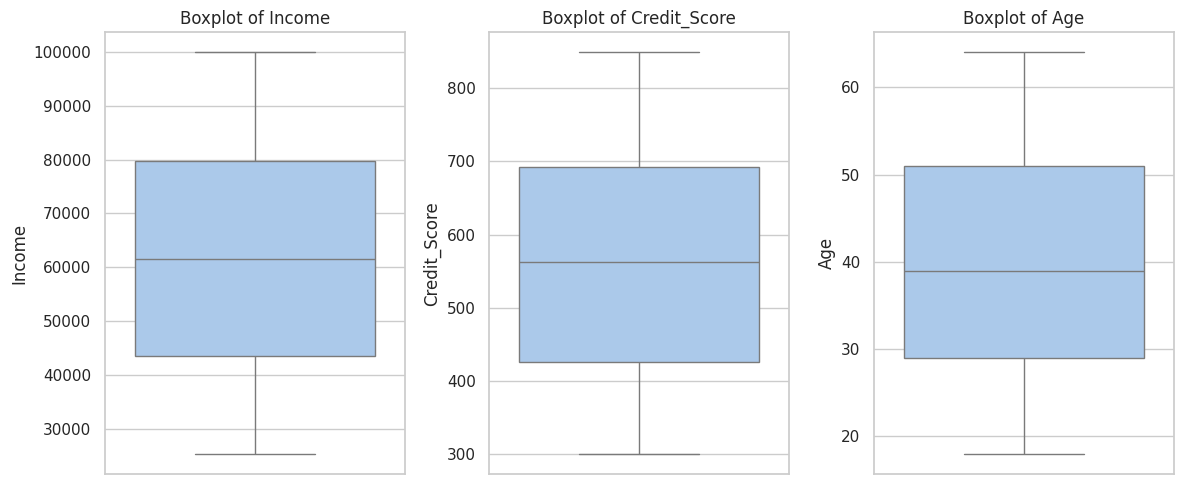

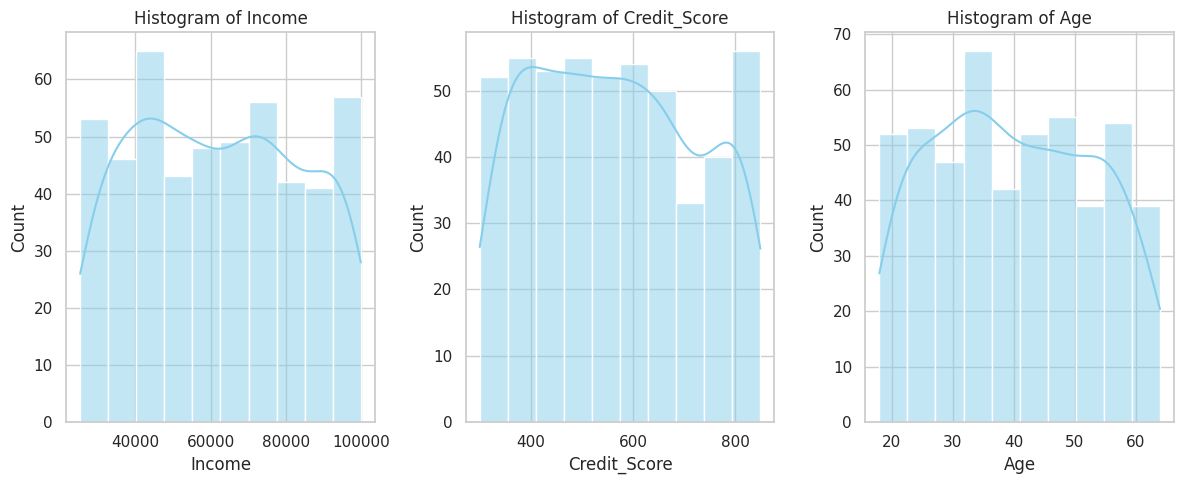

In [12]:
sns.set(style="whitegrid")

# Select numeric columns to check for outliers
numeric_cols = ['Income', 'Credit_Score', 'Age']

# --- Boxplots ---
plt.figure(figsize=(12, 5))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df, y=col, palette='pastel')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# --- Histograms ---
plt.figure(figsize=(12, 5))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=df, x=col, kde=True, color='skyblue')
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

**Interpretation:**

**1. Income**
- The boxplot shows a few **upper outliers**, indicating some customers earn significantly more than the rest.
- The histogram suggests the **Income distribution is slightly right-skewed**, meaning most customers have moderate incomes, with a few very high earners.

**2. Credit Score**
- The boxplot appears relatively compact, showing **few or no extreme outliers**.
- The distribution is fairly **normal**, meaning credit scores are consistent across most customers.

**3. Age**
- The boxplot may reveal **a few higher-age outliers**, representing older customers.
- The histogram shows that most customers fall within a **mid-age range**, with fewer young or elderly clients.


# Part C - Clustering Modeling

In [13]:
df_unscaled = df_encoded.drop(columns=['Education']).copy()
df_scaled = df_encoded.drop(columns=['Education']).copy()

# Drop education because its not numerical data type

In [14]:
df_scaled.dtypes

,0
Income,float64
Age,int64
Credit_Score,int64
Years_with_Bank,int64
Transaction_Count,int64
Balance,float64
Loan_Approval_Amount,float64
Credit_Card_Limit,float64
Purchase_Frequency,float64
Customer_Satisfaction,int64


In [15]:
# Create a StandardScaler object
sc = StandardScaler()

# Fit and transform the selected columns
df_scaled = pd.DataFrame(sc.fit_transform(df_scaled), columns=df_unscaled.columns)

df_scaled.head()

,Income,Age,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
0,0.179150,1.303097,-0.389771,-1.905592,-0.260713,-1.058293,-1.606308,-0.861669,1.636958,-1.421875,-0.992013
1,0.749977,1.533191,1.345561,-1.711263,-0.748287,1.619378,0.428724,-1.189034,1.532620,-0.512748,0.186427
2,0.364249,0.459420,-0.289172,0.620687,1.619930,0.670893,-0.628469,-0.821645,-0.849476,0.396379,1.184595
3,0.165665,0.152629,1.691370,1.203675,0.993049,1.002068,1.392847,-1.422533,1.067226,1.305506,-1.274907
4,-0.250263,-0.307558,-0.974502,0.232029,0.331341,-1.547513,1.628264,-0.083694,-0.588149,1.305506,1.684898


In [16]:
# get stastical information on the new dataset
df_scaled.describe()

,Income,Age,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
count,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,2.158274e-16,1.421085e-16,2.593481e-16,1.598721e-16,9.237056e-17,-3.392842e-16,-1.918465e-16,4.085621e-17,1.492140e-16,-4.973799e-17,-8.171241e-17
std,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00
min,-1.687691e+00,-1.688120e+00,-1.666120e+00,-1.905592e+00,-1.653782e+00,-1.716418e+00,-1.706699e+00,-1.723224e+00,-1.811333e+00,-1.421875e+00,-1.676552e+00
25%,-8.535233e-01,-8.444436e-01,-8.739031e-01,-7.396169e-01,-8.179404e-01,-8.547889e-01,-8.524396e-01,-8.660940e-01,-8.511311e-01,-5.127476e-01,-8.654451e-01
50%,-3.347132e-02,-7.746485e-02,-1.881200e-02,3.769986e-02,-1.692579e-02,-3.416637e-02,8.970695e-03,1.912909e-02,6.587104e-02,3.963794e-01,-3.124291e-02
75%,8.033504e-01,8.429096e-01,7.985545e-01,8.150166e-01,8.189156e-01,8.593735e-01,9.102263e-01,8.839671e-01,8.868705e-01,1.305506e+00,8.997453e-01
max,1.723192e+00,1.839982e+00,1.785682e+00,1.592333e+00,1.759237e+00,1.683474e+00,1.725528e+00,1.681174e+00,1.702529e+00,1.305506e+00,1.717971e+00


## Silhouette Score

## Df_Scaled

Skipping Ward linkage with Manhattan metric (not supported).


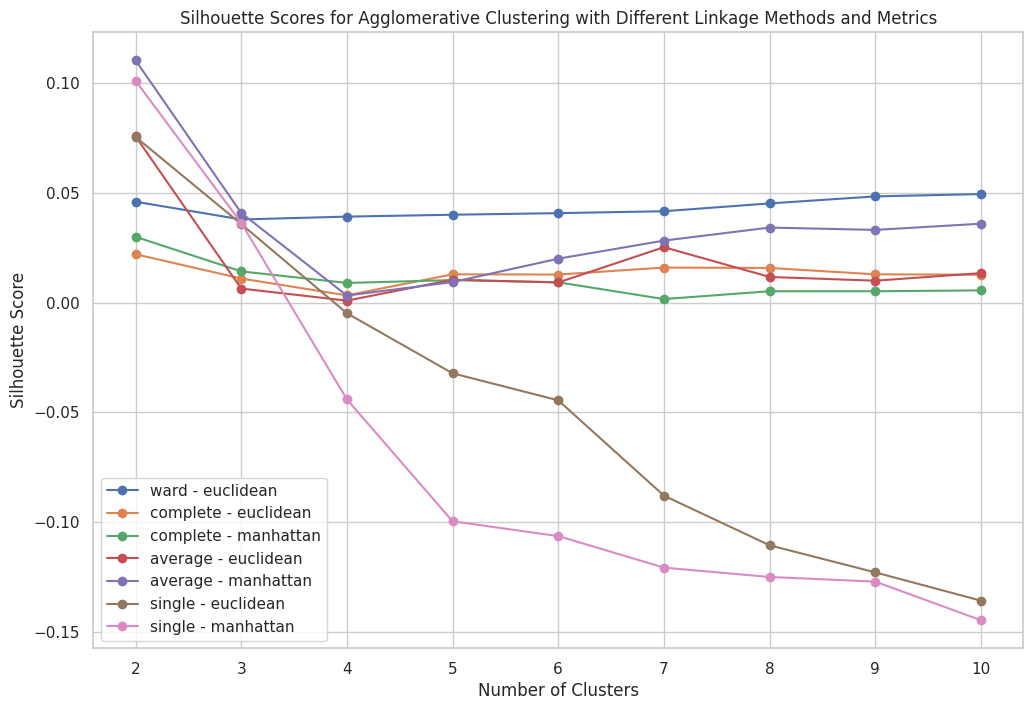

Best Silhouette Score: 0.11028032059064112
Optimal Number of Clusters: 2
Optimal Linkage Method: average
Optimal Metric: manhattan


In [17]:
# Define the range of clusters to test and linkage methods
range_n_clusters = range(2, 11)
linkage_methods = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'manhattan']

best_silhouette_score = -1
best_n_clusters = 0
best_linkage = ''
best_metric = ''

results_for_plotting = []

for linkage_method in linkage_methods:
    for metric in metrics:
        # Skip 'ward' linkage with 'manhattan' metric as it's not supported
        if linkage_method == 'ward' and metric == 'manhattan':
            print(f"Skipping Ward linkage with Manhattan metric (not supported).")
            continue

        current_scores = []
        for n_clusters in range_n_clusters:
            agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, metric=metric)
            y_agglo = agglo.fit_predict(df_scaled)
            silhouette_avg = silhouette_score(df_scaled, y_agglo)
            current_scores.append(silhouette_avg)

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_n_clusters = n_clusters
                best_linkage = linkage_method
                best_metric = metric
        results_for_plotting.append({
            'linkage': linkage_method,
            'metric': metric,
            'scores': current_scores
        })

# Plot the silhouette scores for each linkage method and metric combination
plt.figure(figsize=(12, 8))
for result in results_for_plotting:
    plt.plot(range_n_clusters, result['scores'], marker='o', label=f"{result['linkage']} - {result['metric']}")

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Agglomerative Clustering with Different Linkage Methods and Metrics")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")
print(f"Optimal Linkage Method: {best_linkage}")
print(f"Optimal Metric: {best_metric}")

Best Silhouette Score: 0.11028032059064112

Optimal Number of Clusters: 2

Optimal Linkage Method: average

Optimal Metric: manhattan

### Hierarchical Clustering Model df_scaled

In [18]:
# Hierarchical Clustering using best parameters
agglo_scaled = AgglomerativeClustering(n_clusters=best_n_clusters, linkage=best_linkage, metric=best_metric)
y_hc_scaled = agglo_scaled.fit_predict(df_scaled)

In [19]:
# Evaluation
ss = silhouette_score(df_scaled, y_hc_scaled)
print(ss)

0.11028032059064112


## df_unscaled

Skipping Ward linkage with Manhattan metric (not supported).


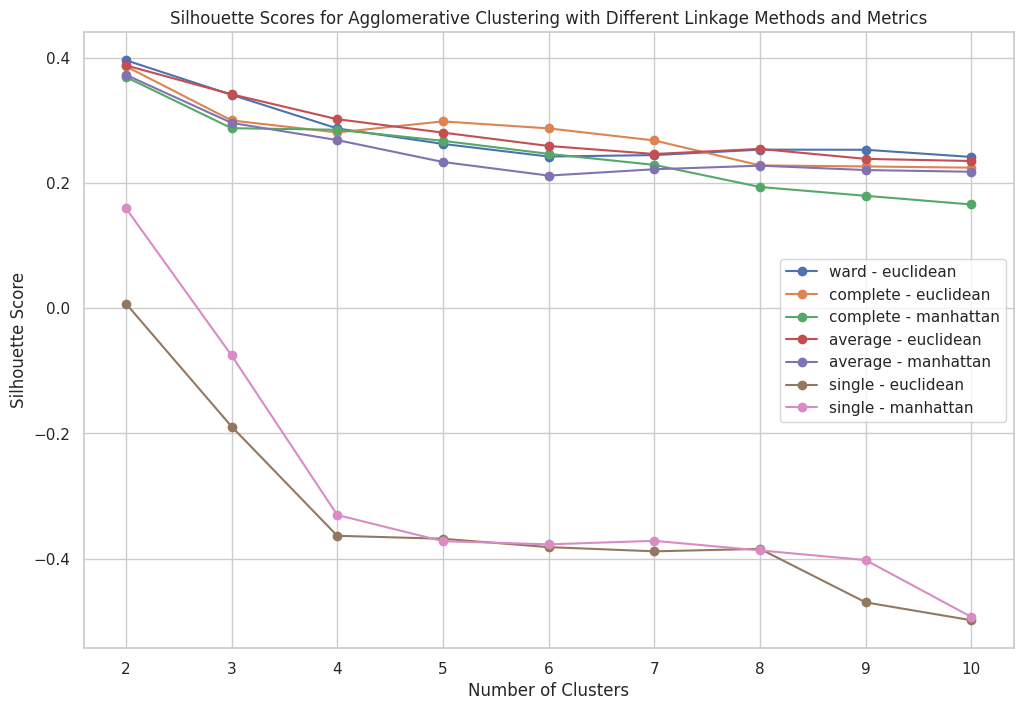

Best Silhouette Score: 0.3957270704224104
Optimal Number of Clusters: 2
Optimal Linkage Method: ward
Optimal Metric: euclidean


In [20]:
# Define the range of clusters to test and linkage methods
range_n_clusters = range(2, 11)
linkage_methods = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'manhattan']

best_silhouette_score = -1
best_n_clusters = 0
best_linkage = ''
best_metric = ''

results_for_plotting = []

for linkage_method in linkage_methods:
    for metric in metrics:
        # Skip 'ward' linkage with 'manhattan' metric as it's not supported
        if linkage_method == 'ward' and metric == 'manhattan':
            print(f"Skipping Ward linkage with Manhattan metric (not supported).")
            continue

        current_scores = []
        for n_clusters in range_n_clusters:
            agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, metric=metric)
            y_agglo = agglo.fit_predict(df_unscaled)
            silhouette_avg = silhouette_score(df_unscaled, y_agglo)
            current_scores.append(silhouette_avg)

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_n_clusters = n_clusters
                best_linkage = linkage_method
                best_metric = metric
        results_for_plotting.append({
            'linkage': linkage_method,
            'metric': metric,
            'scores': current_scores
        })

# Plot the silhouette scores for each linkage method and metric combination
plt.figure(figsize=(12, 8))
for result in results_for_plotting:
    plt.plot(range_n_clusters, result['scores'], marker='o', label=f"{result['linkage']} - {result['metric']}")

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Agglomerative Clustering with Different Linkage Methods and Metrics")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")
print(f"Optimal Linkage Method: {best_linkage}")
print(f"Optimal Metric: {best_metric}")

Best Silhouette Score: 0.3957270704224104

Optimal Number of Clusters: 2

Optimal Linkage Method: ward

Optimal Metric: euclidean

### Hierarchical Clustering Model df_unscaled

In [21]:
# Hierarchical Clustering using best parameters
agglo_unscaled = AgglomerativeClustering(n_clusters=best_n_clusters, linkage=best_linkage, metric=best_metric)
y_hc_unscaled = agglo_scaled.fit_predict(df_unscaled)

In [44]:
# Evaluation
ss = silhouette_score(df_unscaled, y_hc_unscaled)
print(ss)

0.37247068536236905
0.11028032059064112


## Dendogram Visualization for Hierarchical Clustering Model

df_scaled

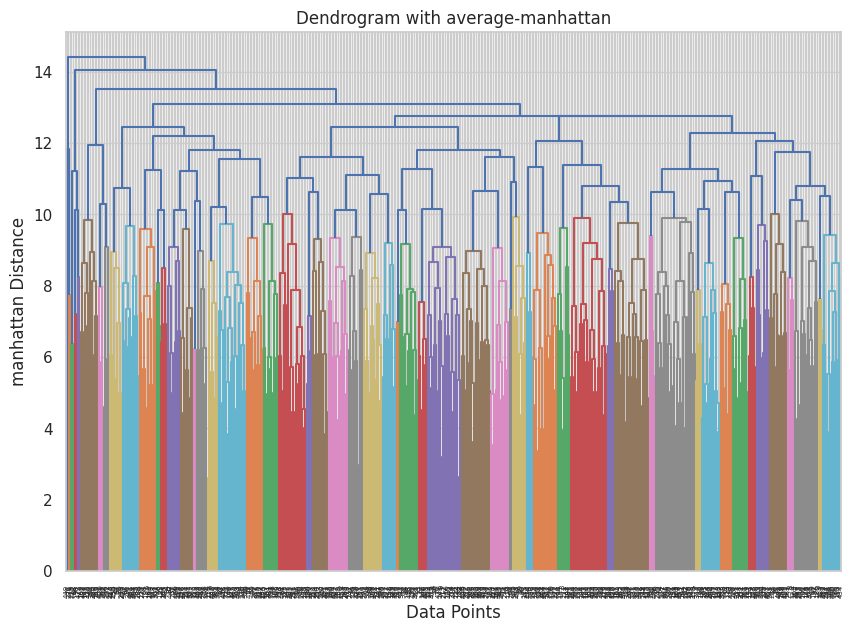

In [23]:
# Average Distance
linked = linkage(df_scaled, method='average', metric='cityblock')
# the correct name for "manhattan" distance is "cityblock"

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked)
plt.title("Dendrogram with average-manhattan")
plt.xlabel("Data Points")
plt.ylabel("manhattan Distance")
plt.show()

df_unscaled

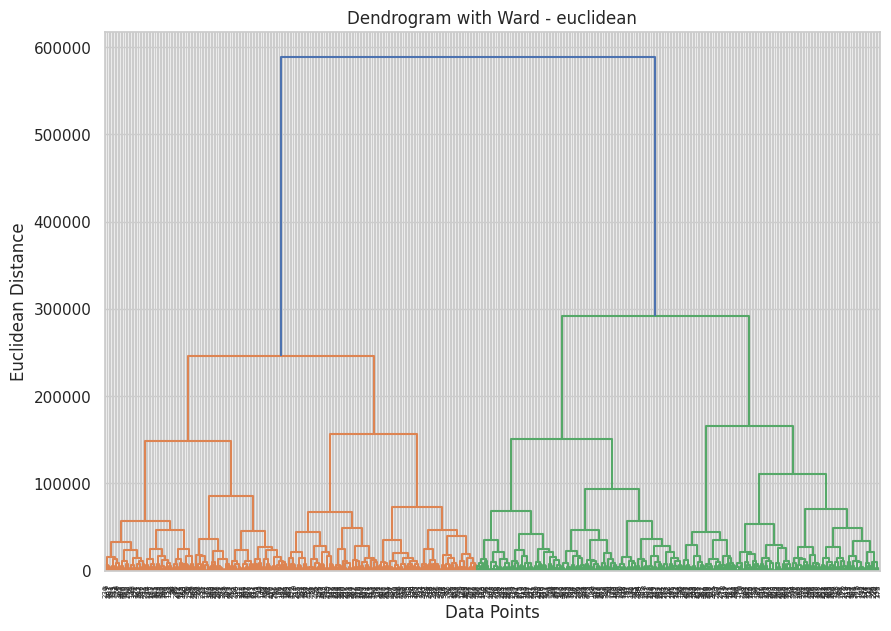

In [24]:
# Average Distance
linked = linkage(df_unscaled, method='ward', metric='euclidean')

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked)
plt.title("Dendrogram with Ward - euclidean")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

## Merge with the original data

### df_scaled (Average-Manhattan)

In [25]:
df_scaled_clustered = df.copy()
# Add the cluster labels to the original data
df_scaled_clustered['Agglo'] = y_hc_scaled

# Analyze the clusters with the original values
df_scaled_clustered.head()

,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity,Agglo
0,66161.01279,57,Bachelor,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693,0
1,78639.20248,60,High School,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358,0
2,70207.25321,46,High School,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993,0
3,65866.23872,42,High School,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473,0
4,56774.10995,36,Bachelor,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168,0


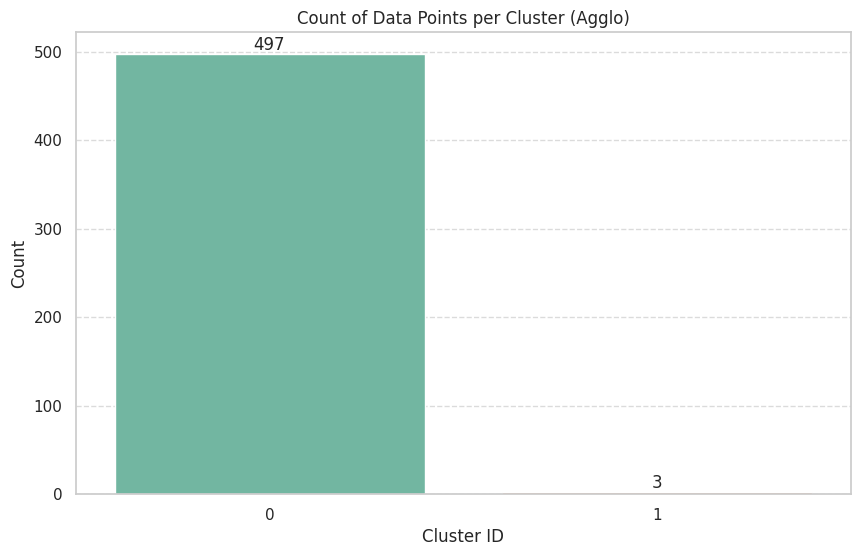

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the counts of each cluster in the 'Agglo' column of df
cluster_counts = df_scaled_clustered['Agglo'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette='Set2', legend=False)

# Add labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.title('Count of Data Points per Cluster (Agglo)')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

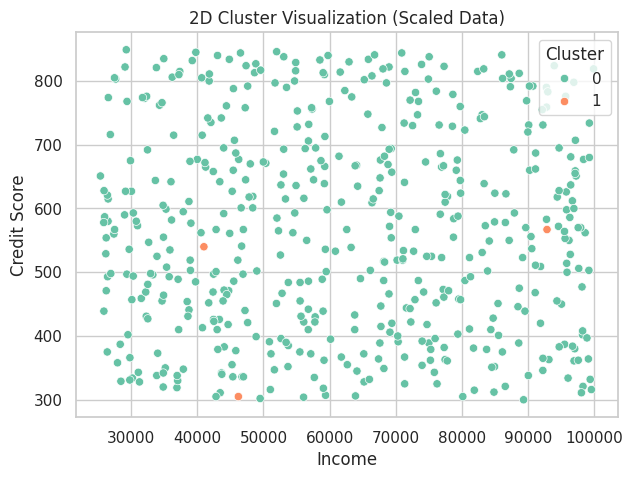

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_scaled_clustered,
    x='Income',
    y='Credit_Score',
    hue='Agglo',
    palette='Set2'
)
plt.title('2D Cluster Visualization (Scaled Data)')
plt.xlabel('Income')
plt.ylabel('Credit Score')
plt.legend(title='Cluster')
plt.show()

In [39]:
fig = px.scatter_3d(
    df_scaled_clustered,
    x='Income',
    y='Credit_Score',
    z='Customer_Satisfaction',
    color='Agglo',
    color_discrete_sequence=px.colors.qualitative.Set2,
    title='3D Cluster Visualization (Scaled Data)'
)
fig.show()

### df_unscaled

In [28]:
df_unscaled_clustered = df.copy()
# Add the cluster labels to the original data
df_unscaled_clustered['Agglo'] = y_hc_unscaled

# Analyze the clusters with the original values
df_unscaled_clustered.head()

,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity,Agglo
0,66161.01279,57,Bachelor,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693,1
1,78639.20248,60,High School,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358,1
2,70207.25321,46,High School,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993,1
3,65866.23872,42,High School,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473,0
4,56774.10995,36,Bachelor,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168,0


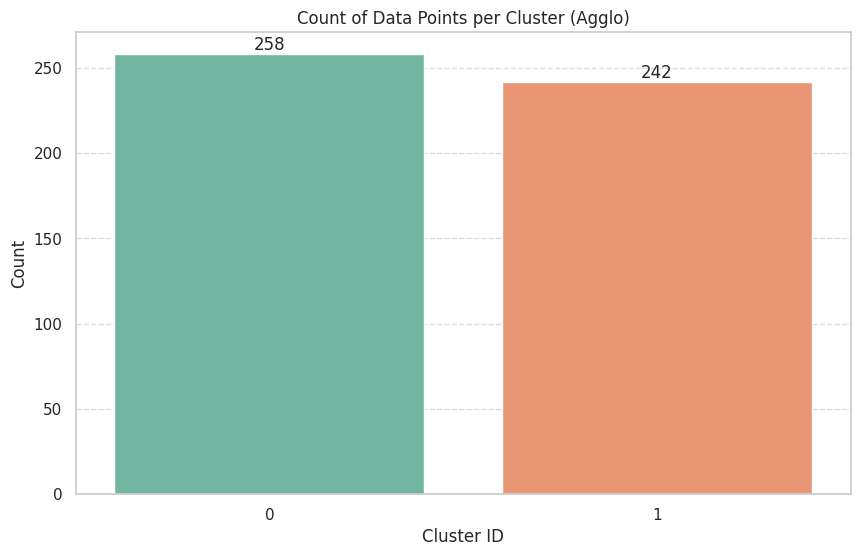

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the counts of each cluster in the 'Agglo' column of df
cluster_counts = df_unscaled_clustered['Agglo'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette='Set2', legend=False)

# Add labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.title('Count of Data Points per Cluster (Agglo)')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

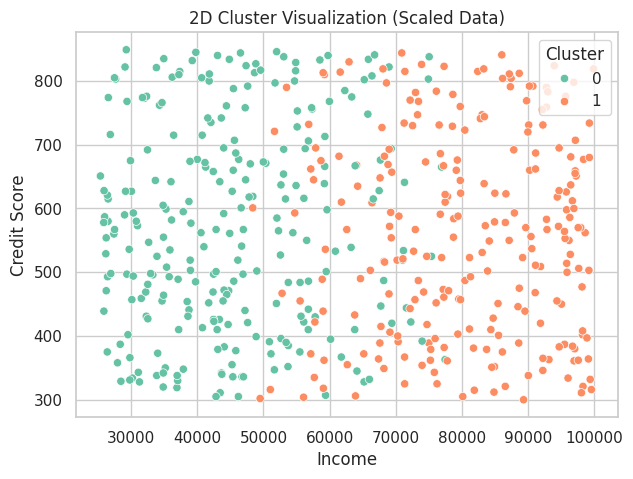

In [40]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_unscaled_clustered,
    x='Income',
    y='Credit_Score',
    hue='Agglo',
    palette='Set2'
)
plt.title('2D Cluster Visualization (Scaled Data)')
plt.xlabel('Income')
plt.ylabel('Credit Score')
plt.legend(title='Cluster')
plt.show()

In [41]:
fig = px.scatter_3d(
    df_unscaled_clustered,
    x='Income',
    y='Credit_Score',
    z='Customer_Satisfaction',
    color='Agglo',
    color_discrete_sequence=px.colors.qualitative.Set2,
    title='3D Cluster Visualization (Scaled Data)'
)
fig.show()

# Part D - Segmentation & Managerial Implication


**Evaluation Results:**
- **Unscaled**  
  - Silhouetter score: **0.3725**  
  - Data points per cluster: **258 - 242**  
- **Scaled**  
  - Evaluation score: **0.1102**  
  - Data points per cluster: **497 - 2**

SS score for **unscaled is bigger** than scaled


**Which version shows clearer cluster separation?**  
- The **unscaled dataset** produced clearer cluster separation, as seen from its higher silhouette score (**0.3725**) and more balanced cluster distribution (**258 vs 242**).  
- The clusters are more distinct because variables with larger numeric ranges (e.g., `Income`, `Balance`) strongly influenced how distances were calculated, creating visibly separated groups.

**Why does scaling affect the clustering result?**  
- Agglomerative (hierarchical) clustering uses **distance-based calculations** (e.g., Euclidean distance) to form clusters.  
- When data is **unscaled**, features with larger ranges dominate the distance metric, meaning clustering decisions are mostly influenced by those variables.  
- When data is **scaled**, all features contribute equally. This often changes how clusters form because the influence of large range variables is reduced.  
- In this dataset, scaling reduced the dominance of high value features, making points appear more similar overall, leading to less distinct clusters (and a lower silhouette score).

**Conclusion:**  
- Although the unscaled data visually shows clearer separation, it's primarily due to **feature magnitude bias**, not necessarily true differences between customers.  
- Scaling ensures fairness among features, so the clustering reflects real relationships, even if the boundaries appear less distinct.


## Statistical Summary for each cluster

### Scaled

In [33]:
# Group the data by cluster and calculate the mean spending and annual income for each cluster
cluster_summary = df.groupby(y_hc_scaled).agg({
    'Income': ['mean', 'median'],
    'Age': ['mean', 'median'],
    'Education': ['first', 'count'],
    'Credit_Score': ['mean', 'median'],
    'Years_with_Bank': ['mean', 'median'],
    'Transaction_Count': ['mean', 'median'],
    'Balance': ['mean', 'median'],
    'Loan_Approval_Amount': ['mean', 'median'],
    'Credit_Card_Limit': ['mean', 'median'],
    'Purchase_Frequency': ['mean', 'median'],
    'Customer_Satisfaction': ['mean', 'median'],
    'Online_Activity': ['mean', 'median']
})

cluster_summary = cluster_summary.rename_axis('cluster')

cluster_summary

Income                     Age        Education        \
                 mean       median       mean median     first count   
cluster                                                                
0        62258.212291  61604.22105  40.070423   40.0  Bachelor   497   
1        60026.682137  46210.52219  30.000000   29.0  Bachelor     3   

        Credit_Score        Years_with_Bank         ... Loan_Approval_Amount  \
                mean median            mean median  ...                 mean   
cluster                                             ...                        
0         565.561368  562.0       10.798793   11.0  ...         25294.922903   
1         470.666667  540.0       12.000000   17.0  ...         42060.838417   

                     Credit_Card_Limit               Purchase_Frequency  \
              median              mean        median               mean   
cluster                                                                   
0        25119.11222      10639.636202  10726.491570           0.509923   
1        44366.09049       5695.677937   2294.811265           0.981597   

                  Customer_Satisfaction        Online_Activity            
           median                  mean median            mean    median  
cluster                                                                   
0        0.530225              2.563380    3.0        0.495256  0.487052  
1        0.983596              2.666667    3.0        0.371986  0.340540  

[2 rows x 24 columns]

## Cluster characteristic & Managerial Recommendations for Scaled

### Cluster 0 — Mid-age, stable customers with balanced engagement

**Interpretation**
- Mature, moderately affluent customers who are loyal and financially stable.
- Moderate digital engagement; prefer a mix of branch + digital channels.
- Opportunity to increase satisfaction and deepen product usage.

**Managerial recommendations**
- **Product design:** Loyalty/retention products (tiered savings rates, loyalty cashbacks, bundled insurance/investment offers). Retirement / long-term wealth products.
- **Marketing:** Hybrid channel campaigns (email + branch + targeted direct mail). Emphasize trust, security, and long-term value (“Your bank for life”).
- **Service:** Proactive relationship management (periodic financial reviews, preferred-customer service lines).
- **Priority:** **Retention**, protect and slightly grow share-of-wallet.

---

### Cluster 1 — Young, digitally active, high-potential customers

**Interpretation**
- Tech-savvy, digitally engaged customers with ambitious borrowing behavior but lower credit scores and lower satisfaction.
- Strong digital usage suggests high responsiveness to app-based offers and communications.

**Managerial recommendations**
- **Product design:** Digital-first, credit-building products (secured cards, microloans, app-based credit scoring, gamified savings). Fast, frictionless loan/credit products with clear credit-improvement paths.
- **Marketing:** App push notifications, social media, in-app promos, influencer or referral campaigns. Emphasize speed, convenience, personalization.
- **Service:** Improve digital UX, faster issue resolution in-app, credit education content and nudges.
- **Priority:** **Growth**, convert high digital engagement into long-term value by improving satisfaction and creditworthiness.

### Unscaled

In [34]:
# Group the data by cluster and calculate the mean spending and annual income for each cluster
cluster_summary = df.groupby(y_hc_unscaled).agg({
    'Income': ['mean', 'median'],
    'Age': ['mean', 'median'],
    'Education': ['first', 'count'],
    'Credit_Score': ['mean', 'median'],
    'Years_with_Bank': ['mean', 'median'],
    'Transaction_Count': ['mean', 'median'],
    'Balance': ['mean', 'median'],
    'Loan_Approval_Amount': ['mean', 'median'],
    'Credit_Card_Limit': ['mean', 'median'],
    'Purchase_Frequency': ['mean', 'median'],
    'Customer_Satisfaction': ['mean', 'median'],
    'Online_Activity': ['mean', 'median']
})

cluster_summary = cluster_summary.rename_axis('cluster')

cluster_summary

Income                      Age           Education        \
                 mean        median       mean median        first count   
cluster                                                                    
0        45215.222822  43942.456825  40.096899   40.0  High School   258   
1        80400.347383  80808.040560  39.917355   39.0     Bachelor   242   

        Credit_Score        Years_with_Bank         ... Loan_Approval_Amount  \
                mean median            mean median  ...                 mean   
cluster                                             ...                        
0         571.399225  562.0       11.317829   12.0  ...         29087.188300   
1         558.161157  559.0       10.260331   10.0  ...         21459.771142   

                      Credit_Card_Limit               Purchase_Frequency  \
               median              mean        median               mean   
cluster                                                                    
0        29772.186095      10416.380834  10092.698925           0.510242   
1        20358.722105      10816.363517  11142.503170           0.515430   

                  Customer_Satisfaction        Online_Activity            
           median                  mean median            mean    median  
cluster                                                                   
0        0.532515              2.546512    2.5        0.521116  0.535615  
1        0.530516              2.582645    3.0        0.466158  0.411963  

[2 rows x 24 columns]

## Cluster characteristic & Managerial Recommendations for Scaled

## Cluster 0 — Mid-age, lower-income, steady customers

**Interpretation**
- These customers are **financially stable but not affluent**.  
- Long-term, loyal clients with **steady engagement** and **moderate satisfaction**.  
- Mostly high-school educated, possibly more traditional in financial habits.  

**Managerial recommendations**
- **Product design:**  
  - Offer **affordable financial products** (basic savings, small personal loans, or installment-based plans).  
  - Introduce **financial literacy programs** or budgeting tools to support this group.  
- **Marketing:**  
  - Focus on **trust, reliability, and simplicity** — highlight financial security and community values.  
  - Use **SMS, WhatsApp, and in-branch campaigns** rather than advanced digital ads.  
- **Service:**  
  - Provide human support options (branch visits, phone service).  
  - Educate about digital services to gradually increase online engagement.  
- **Priority:** **Retention** — maintain this loyal base and increase satisfaction through better support and small incentives.

---

## Cluster 1 — Mid-age, higher-income, educated professionals  

**Interpretation**
- Well-educated, **financially stronger customers** who are comfortable with the bank but **less satisfied**.  
- They may expect more premium services or personalized offers.  
- Balanced online engagement, likely using mobile and web banking regularly.

**Managerial recommendations**
- **Product design:**  
  - Develop **premium or personalized financial services** (wealth management, investment advisory, exclusive rewards).  
  - Offer **flexible credit lines** or high-limit cards with benefits.  
- **Marketing:**  
  - Promote **status-based and lifestyle campaigns** (“Exclusive offers for professionals”).  
  - Use **email and app-based personalization** with advanced targeting.  
- **Service:**  
  - Improve response time and experience in digital channels.  
  - Conduct satisfaction surveys and personalize retention offers.  
- **Priority:** **Growth**, high potential for cross-selling and loyalty improvement.
